**DATA DIRI**

**NAMA : MUHAMMAD ISMAIL**

**DOMISILI : SURABAYA, JAWA TIMUR**

**FINAL PROJECT PENGEMBANGAN ML**

In [3]:
import tensorflow as tf
#mengecek version dari tensorflow
tf.__version__

'2.6.0'

**IMPORT LIBRARY PENTING DAN MENDOWNLOAD DATASET**

In [4]:
# basic librareis
import pandas as pd
import numpy as np
from pathlib import Path
import zipfile
import os
import glob

#plotting and visualization
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns 

# preprocessing
from sklearn.model_selection import train_test_split

#modelling
from keras.models import Model,Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense,Flatten

In [5]:
!pip install kaggle

In [6]:
#mengupload API key akun kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mail2418","key":"784e529f058f35edd5174910c6d63425"}'}

In [7]:
# membuat directory dari kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [8]:
#download dataset
!kaggle datasets download -d chetankv/dogs-cats-images

100% 434M/435M [00:02<00:00, 190MB/s]
100% 435M/435M [00:02<00:00, 169MB/s]


In [9]:
local_zip = 'dogs-cats-images.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close() 

base_dir = 'dataset'

In [10]:
os.listdir(base_dir)

['test_set', 'training_set']

In [11]:
# Create a list with the filepaths for training and testing
dir_ = Path('dataset/training_set')
train_filepaths = list(dir_.glob(r'**/*.jpg'))

dir_ = Path('dataset/test_set')
test_filepaths = list(dir_.glob(r'**/*.jpg'))

**PREPROCESSING DATA**

In [12]:
def ImageProcessing(filepath):

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Foto').astype(str)
    labels = pd.Series(labels, name='Jenis')

    # Meng-concat filepath dan label
    df = pd.concat([filepath, labels], axis=1)

    # Meng-Shuffle DataFrame dan Me-reset index
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df

In [13]:
train_df = ImageProcessing(train_filepaths)
test_df = ImageProcessing(test_filepaths)

print('Jumlah data training adalah: {}' .format(train_df.shape[0]))
print('Jumlah data testing adalah: {}' .format(test_df.shape[0]))

Jumlah data training adalah: 8000
Jumlah data testing adalah: 2000


In [14]:
train_df.head(5)

,Foto,Jenis
0,dataset/training_set/dogs/dog.2888.jpg,dogs
1,dataset/training_set/dogs/dog.338.jpg,dogs
2,dataset/training_set/cats/cat.1643.jpg,cats
3,dataset/training_set/dogs/dog.1409.jpg,dogs
4,dataset/training_set/dogs/dog.3625.jpg,dogs


In [15]:
test_df.head(5)

,Foto,Jenis
0,dataset/test_set/dogs/dog.4797.jpg,dogs
1,dataset/test_set/cats/cat.4460.jpg,cats
2,dataset/test_set/cats/cat.4458.jpg,cats
3,dataset/test_set/dogs/dog.4072.jpg,dogs
4,dataset/test_set/cats/cat.4260.jpg,cats


**VISUALISASI DATA**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


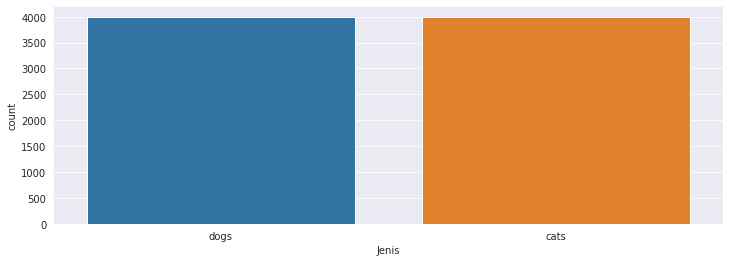

In [16]:
plt.figure(figsize=(12,4))
sns.set_style("darkgrid")
sns.countplot(train_df['Jenis'])

**AUGMENTASI GAMBAR**

In [17]:
#augmentasi gambar
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')
 
test_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

**IMAGE GENERATOR**

In [18]:
#image data generator
img_size = 224
batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe = train_df,
        x_col='Foto',
        y_col='Jenis', 
        target_size=(img_size, img_size),  
        batch_size= batch_size,
        shuffle=True,
        subset = "training",
        class_mode='categorical')
 
# validation_generator = train_datagen.flow_from_dataframe(
#         dataframe = train_df,
#         x_col='Foto',
#         y_col='Jenis', 
#         target_size=(img_size, img_size),  
#         batch_size= batch_size,
#         shuffle=True,
#         subset = "validation",
#         class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col='Foto',
        y_col='Jenis',
        target_size=(img_size, img_size),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=False
    )

Found 8000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


In [19]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       7

In [20]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [21]:
#membuat callback agar menghentikan epoch bila akurasi sesuai dengan yang diinginkan
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') >0.9):
      print("\nAkurasi telah mencapai >90%!")
      self.model.stop_training = True
callbacks = myCallback()

In [22]:
history = model.fit(
      train_generator, 
      epochs = 100,  
      validation_data = test_generator, 
      verbose = 2, 
      callbacks = [callbacks])

Epoch 1/100
250/250 - 521s - loss: 0.6785 - accuracy: 0.5715 - val_loss: 0.6192 - val_accuracy: 0.6570
Epoch 2/100
250/250 - 516s - loss: 0.5775 - accuracy: 0.6948 - val_loss: 0.5264 - val_accuracy: 0.7320
Epoch 3/100
250/250 - 513s - loss: 0.5098 - accuracy: 0.7437 - val_loss: 0.5285 - val_accuracy: 0.7345
Epoch 4/100
250/250 - 512s - loss: 0.4796 - accuracy: 0.7689 - val_loss: 0.4720 - val_accuracy: 0.7710
Epoch 5/100
250/250 - 520s - loss: 0.4438 - accuracy: 0.7921 - val_loss: 0.4775 - val_accuracy: 0.7620
Epoch 6/100
250/250 - 517s - loss: 0.4099 - accuracy: 0.8116 - val_loss: 0.4111 - val_accuracy: 0.8030
Epoch 7/100
250/250 - 515s - loss: 0.3926 - accuracy: 0.8235 - val_loss: 0.3991 - val_accuracy: 0.8225
Epoch 8/100
250/250 - 518s - loss: 0.3716 - accuracy: 0.8313 - val_loss: 0.3808 - val_accuracy: 0.8280
Epoch 9/100
250/250 - 528s - loss: 0.3589 - accuracy: 0.8424 - val_loss: 0.3882 - val_accuracy: 0.8240
Epoch 10/100
250/250 - 523s - loss: 0.3262 - accuracy: 0.8559 - val_loss:

Text(0.5, 1.0, 'Training dan Validation Loss')

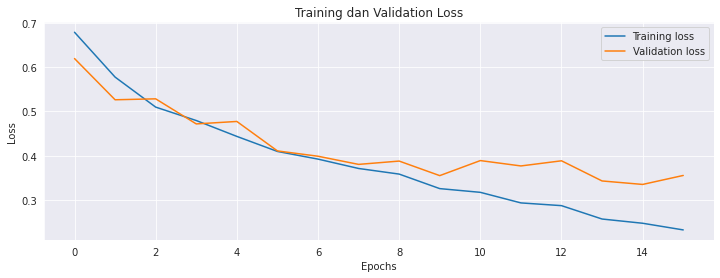

In [24]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend(loc='upper right')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training dan Validation Loss')

Text(0.5, 1.0, 'Training dan Validation Accuracy')

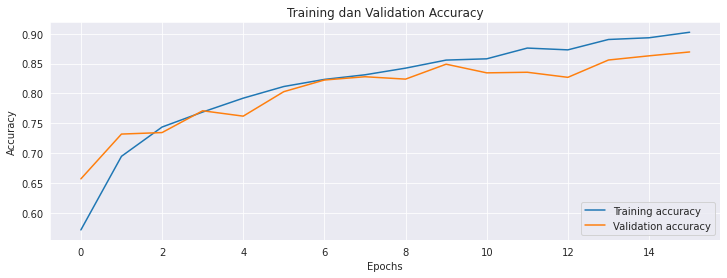

In [27]:
loss = history.history['accuracy']
val_loss = history.history['val_accuracy']

plt.figure(figsize=(12, 4))
plt.plot(loss, label='Training accuracy')
plt.plot(val_loss, label='Validation accuracy')
plt.legend(loc='lower right')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training dan Validation Accuracy')

**KONVERSI MODEL KE TFLITE**

In [28]:
# Konversi model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp9nvau29u/assets


In [29]:
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)